<a href="https://colab.research.google.com/github/divyansh-pathak129/BadhKavach_HackAIThon/blob/main/Flood_Map_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import random

In [ ]:
def heightmap(height):

  if not os.path.exists(height):
    print(f"Warning: Segmentation map file not found: {height}")

  else:
    h_map = cv2.imread(height)

  # Extracting height and width to resize the image and maintain aspect ratio

    h, w = h_map.shape[:2]
    ratio = 256/w
    resized_h = cv2.resize(h_map,(256,int(h*ratio)))

    height_map = cv2.cvtColor(resized_h, cv2.COLOR_BGR2GRAY)

    max_h = np.unravel_index(np.argmax(height_map), height_map.shape)

  # Setting a height rating value

    height_rating = np.zeros(height_map.shape,dtype = 'float32')
    for i in range(0,height_map.shape[0]):
      for j in range(0,height_map.shape[1]):
        height_rating[i][j] = height_map[i][j]/height_map[max_h[0],max_h[1]]

    return height_rating

In [ ]:
def segmentationmap(segmentation):

  if not os.path.exists(segmentation):
    print(f"Warning: Segmentation map file not found: {segmentation}")


  else:
    s_map = cv2.imread(segmentation,cv2.IMREAD_COLOR)

  # Extracting height and width to resize the image and maintain aspect ratio

    h, w = s_map.shape[:2]
    ratio = 256/w
    resized_s = cv2.resize(s_map,(256,int(h*ratio)))

  # Creating an array for the segmentation map (shape = 256x256x3)

    seg_map = cv2.cvtColor(resized_s, cv2.COLOR_BGR2RGB)

  # Creating an array to store the terrain data of each pixel

    terrain = np.zeros((seg_map.shape[0], seg_map.shape[1]), dtype='float32')
    for i in range (0,seg_map.shape[0]):
      for j in range (0,seg_map.shape[1]):
        if np.array_equal(seg_map[i,j], [128,0,128]):# Village Houses
          terrain[i][j] = 8
        elif np.array_equal(seg_map[i,j], [17,141,215]):# Water
          terrain[i][j] = 1
        elif np.array_equal(seg_map[i,j], [225,227,155]):# Grasslands
          terrain[i][j] = 2
        elif np.array_equal(seg_map[i,j], [127,173,123]):# Forest
          terrain[i][j] = 3
        elif np.array_equal(seg_map[i,j], [185,122,87]):# Hills
          terrain[i][j] = 4
        elif np.array_equal(seg_map[i,j], [230,200,181]):# Desert
          terrain[i][j] = 5
        elif np.array_equal(seg_map[i,j], [150,150,150]):# Mountains
          terrain[i][j] = 6
        elif np.array_equal(seg_map[i,j], [193,190,175]):# Tundra
          terrain[i][j] = 7

    return seg_map,terrain

In [ ]:
# Makes the dataset for the input data (50 different maps)

dataset = np.zeros((60,256,256,2),dtype = 'float32')

for a in range(0,6):
  for b in range(0,10):

    height_path = f"/content/00{a}{b}_h.png"
    seg_path = f"/content/00{a}{b}_v.png"

    if not os.path.exists(height_path):
      print(f"Warning: Height map file not found: {height_path}")
      continue
    if not os.path.exists(seg_path):
      print(f"Warning: Segmentation map file not found: {seg_path}")
      continue

    height_rating = heightmap(height_path)
    seg_map,terrain = segmentationmap(seg_path)

    # Stores the data for each map

    data = np.zeros((terrain.shape[0],terrain.shape[1],2), dtype = 'float32')

    for i in range (0,terrain.shape[0]):
      for j in range (0,terrain.shape[1]):
        data[i][j][0] = height_rating[i][j]
        data[i][j][1] = terrain[i][j]

    dataset[10*a + b] = data


In [ ]:
# Makes the dataset for flood data

flood_data = np.zeros((60,256,256,3),dtype = 'float32')

for a in range(0,6):
  for b in range(0,10):

    # Converting each Floodmap into array

    flood_path = f"/content/00{a}{b}_f.png"

    if not os.path.exists(flood_path):
      print(f"Warning: Segmentation map file not found: {flood_path}")
      continue

    flood = cv2.imread(flood_path)
    flood_map = cv2.cvtColor(flood, cv2.COLOR_BGR2RGB)

    max_f = np.unravel_index(np.argmax(flood_map), flood_map.shape)

    # Stores the data for each flood map

    flood_rating = np.zeros(flood_map.shape,dtype = 'float32')
    for i in range(0,flood_map.shape[0]):
      for j in range(0,flood_map.shape[1]):
        flood_rating[i][j] = flood_map[i][j]/flood_map[max_f[0],max_f[1]]

    flood_data[a*10 + b] = flood_rating


In [ ]:
def create_model():
    inputs = keras.Input(shape=(256, 256, 2))

    # A series of convolutional layers
    x = layers.Conv2D(16, 3, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(16, 3, padding='same', activation='relu')(x)

    # Final layer with 3 filters to get to the target shape
    outputs = layers.Conv2D(3, 1, padding='same')(x)

    outputs = layers.Reshape((256, 256, 3))(outputs)

    # Creating the model

    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compiling the model

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

In [ ]:
# Creating the model
floodmap_generator = create_model()
floodmap_generator.summary()
floodmap_generator.fit(dataset, flood_data, epochs=60, batch_size=5)

floodmap_generator.save("floodmap_generator.keras")  # Saves the model in HDF5 format
print("Model saved successfully.")


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 2)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 16)        │             304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 256, 256, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 256, 256, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 256, 256, 3)         │              51 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 256, 256, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,619 (37.57 KB)

 Trainable params: 9,619 (37.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.5820
Epoch 2/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.3241
Epoch 3/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.2635
Epoch 4/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.1967
Epoch 5/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.2137
Epoch 6/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.1682
Epoch 7/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 938ms/step - loss: 0.1160
Epoch 8/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.1001
Epoch 9/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.0589
Epoch 10/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - loss: 0.0333
Epoch 11/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.0226
Epoch 12/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 992ms/step - loss: 0.0188
Epoch 13/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0168
Epoch 14/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.0179
Epoch 15/60
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0177
Epoch 16/60
1

In [ ]:
height_input = input("Enter the height map path: ")
seg_input = input("Enter the segmentation map path:")

# Retrieving the data for the maps

height_rating = heightmap(height_input)
seg_map,terrain = segmentationmap(seg_input)

data = np.zeros((terrain.shape[0],terrain.shape[1],2), dtype = 'float32')
for i in range (0,terrain.shape[0]):
  for j in range (0,terrain.shape[1]):
    data[i][j][0] = height_rating[i][j]
    data[i][j][1] = terrain[i][j]

reshaped_data = data.reshape(1, data.shape[0], data.shape[1], data.shape[2])

# Getting the predicted flood map
flood_map = floodmap_generator.predict(reshaped_data)
flood_map = flood_map.reshape(256,256,3)

Enter the height map path: 0003_h.png
Enter the segmentation map path:0003_v.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


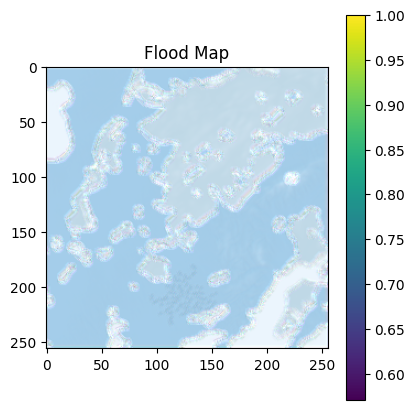

In [ ]:
# Displaying the flood map
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(flood_map)
plt.title('Flood Map')
plt.colorbar()
plt.show()

In [ ]:
# Finding the approximate area the village occupies and extracting the corresponding regions from all the maps
def village(data):
  village = 0
  min_x,min_y = 256,256
  max_x,max_y = 0,0
  for i in range(data.shape[0]):
    for j in range(data.shape[1]):
      if data[i][j][1] == 8:
        village = 1
        min_x = min(min_x, j)
        min_y = min(min_y, i)
        max_x = max(max_x, j)
        max_y = max(max_y, i)

  top_left = (min_x,min_y)
  bottom_right = (max_x,max_y)

  if village == 1:
    for k in range (0,7):
      if max_x<data.shape[0]:
        max_x += 1
      if max_y<data.shape[1]:
        max_y += 1
      if min_x>0:
        min_x -= 1
      if min_y>0:
        min_y -= 1
    top_left_l = (min_x,min_y)
    bottom_right_l = (max_x,max_y)

    rectangle = cv2.rectangle(seg_map, top_left,bottom_right,(0, 255, 0), 1)
    rectangle_2 = cv2.rectangle(seg_map, top_left_l,bottom_right_l,(0, 255, 0), 1)

  else:
    print("Village region not found or is empty.")

  seg_map_copy = seg_map
  flood_map_copy = flood_map
  height_rating_copy = height_rating
  data_copy = data

  return min_x,min_y,max_x,max_y,seg_map_copy,flood_map_copy,height_rating_copy,data_copy

In [ ]:
min_x,min_y,max_x,max_y,seg_map_copy,flood_map_copy,height_rating_copy,data_copy = village(data)

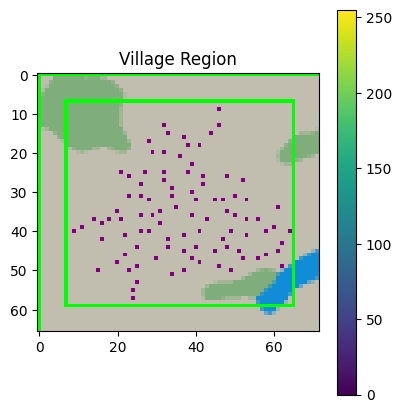

array([0.6767236 , 0.81608874, 0.9143011 ], dtype=float32)

In [ ]:
if min_y < max_y and min_x < max_x:
  village_region = seg_map_copy[min_y:max_y, min_x:max_x]
  plt.figure(figsize=(10, 5))
  plt.subplot(121)
  plt.imshow(village_region)
  plt.title('Village Region')
  plt.colorbar()
  plt.show()
  flood_region = flood_map_copy[min_y:max_y, min_x:max_x]
  height_region = height_rating_copy[min_y:max_y, min_x:max_x]
  data_region = data_copy[min_y:max_y,min_x:max_x]
else:
  print("Village region not found or is empty.")

avg_f = np.mean(flood_region,axis=(0, 1))
avg_f


In [ ]:
j = 6
while j < village_region.shape[1]-6:
    group = random.randint(2,5)

    if j>=village_region.shape[1]*2/5 and j<village_region.shape[1]*3/5:
      i = 2
    elif j>village_region.shape[1]/5 and j<village_region.shape[1]*4/5:
      i = 4
    elif j>0 and j<village_region.shape[1]:
      i = 6

    for k in range(group):
      if j + k < village_region.shape[1]-6:
        if height_region[i][j+k] < 0.03 or np.all(flood_region[i][j+k]<[avg_f[0],avg_f[1],avg_f[2]]):
          if data_region[i][j+k][1]!=1:
            height_region[i][j+k] = 0.20
            village_region[i][j+k] = [255, 255, 255]

    gap = random.randint(2,4)
    j += group + gap

j2 = 6
while j2 < village_region.shape[1]-6:
    group = random.randint(2,5)

    if j2>=village_region.shape[1]*2/5 and j2<village_region.shape[1]*3/5:
      i2 = village_region.shape[0] - 2
    elif j2>village_region.shape[1]/5 and j2<village_region.shape[1]*4/5:
      i2 = village_region.shape[0] - 4
    elif j2>0 and j2<village_region.shape[1]:
      i2 = village_region.shape[0] - 6

    for k in range(group):
      if j2 + k < village_region.shape[1]-6:
        if height_region[i2][j2+k] < 0.03 or np.all(flood_region[i2][j2+k]<[avg_f[0],avg_f[1],avg_f[2]]):
          if data_region[i2][j2+k][1]!=1:
            height_region[i2][j2+k] = 0.20
            village_region[i2][j2+k] = [255, 255, 255]


    gap = random.randint(2,4)
    j2 += group + gap

i = 6
while i < village_region.shape[0]-6:
    group = random.randint(2,5)

    if i>=village_region.shape[0]*2/5 and i<village_region.shape[0]*3/5:
      j = 2
    elif i>village_region.shape[0]/5 and i<village_region.shape[0]*4/5:
      j = 4
    elif i>0 and i<village_region.shape[0]:
      j = 6

    for k in range(group):
      if i + k < village_region.shape[0]-6:
        if height_region[i+k][j] < 0.03 or np.all(flood_region[i+k][j]<[avg_f[0],avg_f[1],avg_f[2]]):
          if data_region[i+k][j][1]!=1:
            height_region[i+k][j] = 0.20
            village_region[i+k][j] = [255, 255, 255]

    gap = random.randint(2,4)
    i += group + gap

i2 = 6
while i2 < village_region.shape[0]-6:
    group = random.randint(2,5)

    if i2>=village_region.shape[0]*2/5 and i2<village_region.shape[0]*3/5:
      j2 = village_region.shape[1] - 2
    elif i2>village_region.shape[0]/5 and i2<village_region.shape[0]*4/5:
      j2 = village_region.shape[1] - 4
    elif i2>0 and i2<village_region.shape[0]:
      j2 = village_region.shape[1] - 6

    for k in range(group):
      if i2 + k < village_region.shape[0]-6:
        if height_region[i2+k][j2] < 0.03 or np.all(flood_region[i2+k][j2]<[avg_f[0],avg_f[1],avg_f[2]]):
          if data_region[i2+k][j2][1]!=1:
            height_region[i2+k][j2] = 0.20
            village_region[i2+k][j2] = [255, 255, 255]


    gap = random.randint(2,4)
    i2 += group + gap

In [ ]:
def flood_reducer(image, center=None, radius=None, jitter=0.4):
    height, width = image.shape[0], image.shape[1]

    if center is None:
        center = (width // 2, height // 2)

    if radius is None:
        radius = min(width, height) // 4

    circle_points = []

    for y in range(height):
        for x in range(width):

            dx = x - center[0]
            dy = y - center[1]
            distance = np.sqrt(dx**2 + dy**2)

            angle = np.arctan2(dy, dx)
            random.seed(int(angle * 1000))
            varied_radius = radius * (1 + (random.random() * 2 - 1) * jitter)

            if distance <= varied_radius:
                circle_points.append((x, y))

    return circle_points

points = flood_reducer(village_region)

for i,j in points:
  flood_region[i][j][0] *= 0.900
  flood_region[i][j][1] *= 0.952
  flood_region[i][j][2] *= 1.000

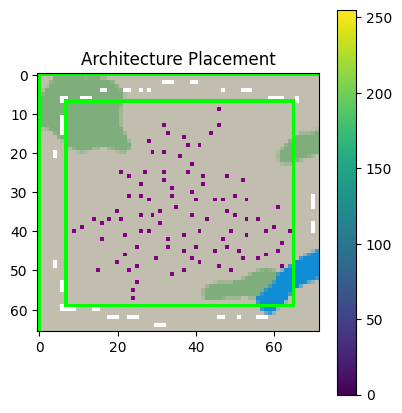

In [ ]:
if min_y < max_y and min_x < max_x:
  plt.figure(figsize=(10, 5))
  plt.subplot(121)
  plt.imshow(village_region)
  plt.title('Architecture Placement')
  plt.colorbar()
  plt.show()

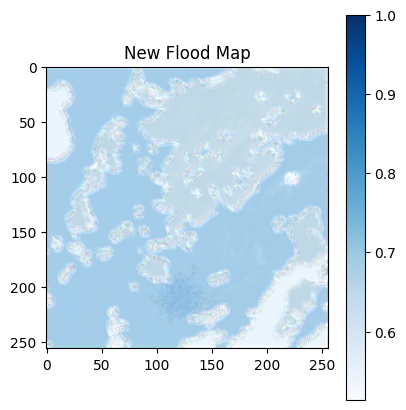

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(flood_map_copy, cmap = 'Blues')
plt.title('New Flood Map')
plt.colorbar()
plt.show()

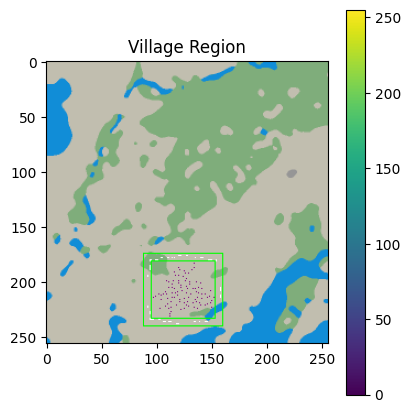

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(seg_map_copy)
plt.title('Village Region')
plt.colorbar()
plt.show()

In [ ]:
!pip install flask flask-cors pyngrok

In [ ]:
from flask import Flask, request, jsonify
from flask_cors import CORS
from pyngrok import ngrok

In [ ]:
app = Flask(__name__)
CORS(app)